## Подготовка данных

**Импорт библиотек:**

In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

**Считываем данные:**

In [3]:
data = pd.read_csv('data/energydata_complete.csv')

In [4]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


**Перед нами `time-series`данные, со следующим набором features(`Appliances` - целевая переменная, label):**

In [5]:
data.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

**1. Переведем стоблец `data` к формату `datetime`**  
**2. Создадим признак `week` в которой содержится номер недели - `weekofyear`:**

In [7]:
data['date'] = data['date'].apply(pd.to_datetime)
data['week'] = data['date'].apply(lambda t: t.weekofyear)

**Посмортим на количество записей сгруппированных по неделям - `week`:**

In [13]:
data.groupby('week')[['date']].count()

,date
week,
2,906
3,1008
4,1008
5,1008
6,1008
7,1008
8,1008
9,1008
10,1008


**Оставим только недели с 3 по 20:**

In [14]:
data.drop(data[(data['week'] < 3) | (data['week'] > 20)].index, axis=0, inplace=True)

**Сделаем столбец `date` индексом:**

In [16]:
data = data.set_index('date')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18144 entries, 2016-01-18 00:00:00 to 2016-05-22 23:50:00
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   18144 non-null  int64  
 1   lights       18144 non-null  int64  
 2   T1           18144 non-null  float64
 3   RH_1         18144 non-null  float64
 4   T2           18144 non-null  float64
 5   RH_2         18144 non-null  float64
 6   T3           18144 non-null  float64
 7   RH_3         18144 non-null  float64
 8   T4           18144 non-null  float64
 9   RH_4         18144 non-null  float64
 10  T5           18144 non-null  float64
 11  RH_5         18144 non-null  float64
 12  T6           18144 non-null  float64
 13  RH_6         18144 non-null  float64
 14  T7           18144 non-null  float64
 15  RH_7         18144 non-null  float64
 16  T8           18144 non-null  float64
 17  RH_8         18144 non-null  float64
 18  T9         

**Перводем все столбцы(кроме `week`) в формат `float64`:**

In [18]:
data['Appliances'] = data['Appliances'].astype('float')
data['lights'] = data['lights'].astype('float')

In [19]:
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-18 00:00:00,60.0,10.0,21.823333,39.900000,20.230000,40.0000,20.323333,39.79,21.166667,39.863333,...,38.400000,-2.800000,763.700000,86.0,2.0,25.0,-4.900000,2.995012,2.995012,3
2016-01-18 00:10:00,50.0,10.0,21.790000,39.933333,20.166667,40.0900,20.390000,39.79,21.100000,39.826667,...,38.466667,-2.883333,763.583333,86.0,2.0,25.5,-4.983333,7.407794,7.407794,3
2016-01-18 00:20:00,40.0,10.0,21.730000,40.000000,20.075000,40.0675,20.323333,39.79,21.100000,39.900000,...,38.400000,-2.966667,763.466667,86.0,2.0,26.0,-5.066667,3.649394,3.649394,3
2016-01-18 00:30:00,30.0,20.0,21.666667,40.000000,20.000000,40.0000,20.290000,39.70,21.100000,39.933333,...,38.466667,-3.050000,763.350000,86.0,2.0,26.5,-5.150000,2.144295,2.144295,3
2016-01-18 00:40:00,40.0,0.0,21.600000,40.193333,19.945000,40.0000,20.260000,39.76,21.100000,40.000000,...,38.590000,-3.133333,763.233333,86.0,2.0,27.0,-5.233333,26.123064,26.123064,3


**Визуализируем последнюю неделю:**

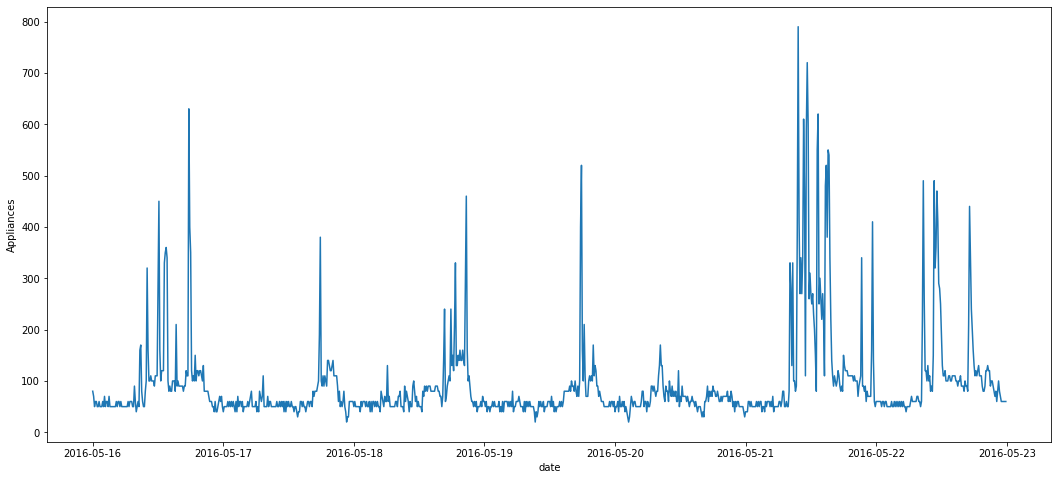

In [27]:
plt.figure(figsize=(18, 8));
plt.plot(data[['Appliances']][data['week']==20]);
plt.xlabel('date');
plt.ylabel('Appliances');

## Валидация

**Деление выборки на объекты(признаки) - X и метки(целевая переменная) - y**:

In [29]:
X = data.drop('Appliances', axis=1)
y = data[['Appliances']]

**Разобъём датасет на 2 части:**

1. Данные за недели 19-20 – тестовая выборка
2. Недели 3-18 – обучающая выборка

In [30]:
X_train = X[X['week'] < 19]
X_test = X[X['week'] >= 19]

y_train = y[:X_train.index[-1]]
y_test = y[X_test.index[0]:]

**Взглянем на размерности выборок:**

In [31]:
X_train.shape, y_train.shape

((16128, 28), (16128, 1))

In [32]:
X_test.shape, y_test.shape

((2016, 28), (2016, 1))

## Градиентный бустинг - XGBoost

**Подготовим данные:**

In [35]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
dall = xgb.DMatrix(X, y)

**Зададим параметры модели:**

In [36]:
# Глубина D=4, количество деревьев N=200
max_depth = 4
params = {'max_depth': max_depth}
num_rounds = 200

**Обучим модель:**

In [37]:
%%time

xgb_model = xgb.train(params, dtrain, num_rounds)

Wall time: 2.07 s


**Визуализируем feature importances (top-10):**

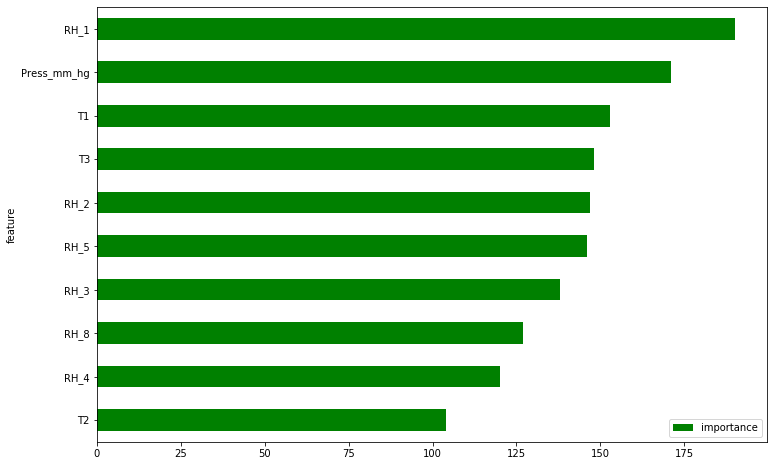

In [45]:
importances = xgb_model.get_fscore()
importances_df = pd.DataFrame({'importance': list(importances.values()), 'feature': list(importances.keys())})
importances_df.sort_values('importance').tail(10).plot(kind='barh', x='feature', figsize=(12, 8), color='green');

**F score при оценке важности признаков в Xgboost вычисляется на основе того, как часто разбиение делалось по данному признаку**

**Функция, которая возвращает суммарное количество листьев у depth-wise tree глубины D:**

In [46]:
def count_leaf(max_depth):
    
    L = 0
    
    for i in np.arange(max_depth+1):
        
        L += 2 ** i
        
    return L

In [47]:
L = count_leaf(max_depth)

**Получим прогнозы в виде перевода в новое признаковое пространство:  
Каждый объект, когда прогоняется через бустинг, попадает в конкретный лист в каждом дереве. Если в каждом дереве L листьев, тогда всего у бустинга (N * L) листьев. Таким образом, объект можно представить как вектор из N индексов, где на i-й позиции номер листа, в который попал объект в i-ом дереве.**

In [48]:
predict_leaf_all = xgb_model.predict(dall, pred_leaf = True)

**Конвертируем листья из `[0; L)` в `[0, N*L)`:**

In [63]:
delta = np.array([]) 
step = 0
for i in range(predict_leaf_all.shape[1]):
    delta = np.append(delta, step)
    step += L

In [66]:
convert_predict_all = predict_leaf_all + vector

**Перведем `convert_predict_all` в `DataFrame`:**

In [68]:
columns = []

for num in np.arange(num_rounds):
    column = 'tree_' + str(num + 1)
    columns.append(column)

In [69]:
convert_predict_all_df = pd.DataFrame(convert_predict_all, columns=columns)

In [70]:
convert_predict_all_df

,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9,tree_10,...,tree_191,tree_192,tree_193,tree_194,tree_195,tree_196,tree_197,tree_198,tree_199,tree_200
0,30.0,57.0,92.0,113.0,144.0,169.0,205.0,244.0,265.0,298.0,...,5916.0,5948.0,5965.0,5998.0,6034.0,6066.0,6102.0,6122.0,6168.0,6182.0
1,30.0,57.0,92.0,113.0,144.0,169.0,205.0,244.0,265.0,298.0,...,5916.0,5948.0,5965.0,5998.0,6034.0,6066.0,6102.0,6122.0,6168.0,6182.0
2,30.0,57.0,92.0,113.0,144.0,169.0,205.0,244.0,265.0,298.0,...,5916.0,5948.0,5965.0,5998.0,6034.0,6066.0,6102.0,6122.0,6168.0,6182.0
3,30.0,57.0,92.0,113.0,154.0,169.0,205.0,244.0,265.0,298.0,...,5916.0,5948.0,5965.0,5998.0,6034.0,6066.0,6102.0,6122.0,6168.0,6182.0
4,20.0,53.0,82.0,113.0,144.0,169.0,205.0,244.0,265.0,298.0,...,5916.0,5948.0,5965.0,5998.0,6034.0,6066.0,6102.0,6122.0,6168.0,6182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18139,22.0,53.0,84.0,123.0,146.0,179.0,212.0,245.0,266.0,301.0,...,5916.0,5948.0,5968.0,5998.0,6034.0,6065.0,6104.0,6135.0,6168.0,6189.0
18140,22.0,53.0,84.0,123.0,146.0,179.0,212.0,245.0,266.0,301.0,...,5916.0,5948.0,5968.0,5998.0,6034.0,6065.0,6104.0,6135.0,6168.0,6189.0
18141,22.0,53.0,84.0,123.0,146.0,179.0,212.0,245.0,266.0,301.0,...,5916.0,5948.0,5968.0,5998.0,6034.0,6065.0,6104.0,6135.0,6168.0,6189.0
18142,22.0,53.0,84.0,123.0,146.0,179.0,212.0,245.0,266.0,301.0,...,5916.0,5948.0,5968.0,5998.0,6034.0,6065.0,6104.0,6135.0,6168.0,6189.0


**Функция, котрая переводит индексы листьев в `One Hot Encoding`:**

In [71]:
def one_hot_encoding(data, start=0, L=31, N=num_rounds):
    
    step = L
    df = pd.DataFrame()
    
    for num in np.arange(N):
        
        key = 'tree_' + str(num + 1)

        arange = np.arange(start, L)

        start = L
        L += step
    
        df[key] = list(arange)
        
    df_ohe = pd.get_dummies(data.append(df), columns=data.columns)
        
    return df_ohe.iloc[:-step, :]

**Получим X_all:**

In [72]:
X_all = one_hot_encoding(convert_predict_all_df)

In [73]:
X_all.head()

,tree_1_0.0,tree_1_1.0,tree_1_2.0,tree_1_3.0,tree_1_4.0,tree_1_5.0,tree_1_6.0,tree_1_7.0,tree_1_8.0,tree_1_9.0,...,tree_200_6190.0,tree_200_6191.0,tree_200_6192.0,tree_200_6193.0,tree_200_6194.0,tree_200_6195.0,tree_200_6196.0,tree_200_6197.0,tree_200_6198.0,tree_200_6199.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Линейная регрессия 

**Поверх полученной матрицы из нулей и единиц обучаем линейную регрессию:**

**Разобьем выборку `X_all` на `train_set` и `test_set`:**

In [74]:
train_set = X_all.iloc[:len(X_train), :]
test_set = X_all.iloc[len(X_train):, :]

**Проверим размерность:**

In [75]:
print('Длина train_set: {}, длина y_train: {}'.format(len(train_set), len(y_train)))

print('\nДлина test_set: {}, длина y_test: {}'.format(len(test_set), len(y_test)))

Длина train_set: 16128, длина y_train: 16128

Длина test_set: 2016, длина y_test: 2016


**Задаим линейную регрессию. Будем пользовать Lasso регрессией, для L1 регуляризации:**

In [79]:
lasso = Lasso(alpha=0.666)

**Обучим модель на `train_set`:**

In [80]:
%%time

lasso.fit(train_set, y_train)

Wall time: 2.58 s


Lasso(alpha=0.666)

**Узнаем, сколько признаков отключилось:**

In [81]:
count_of_weight_0 = 0

for coef in lasso.coef_:
    
    if coef == 0:
        
        count_of_weight_0 += 1

print('Всего {} признаков, из них отключилось {} признаков'.format(len(lasso.coef_), count_of_weight_0))
print('\nОтключилось {:.2f}% признаков'.format(count_of_weight_0 / len(lasso.coef_) * 100))

Всего 6200 признаков, из них отключилось 6046 признаков

Отключилось 97.52% признаков


**Визуализируем веса регрессии для первых 10 деревьев:**  
Первые 10 деревьев - признаки `tree_1_0`, ... , `tree_1_30`, `tree_2_31`, ... , `tree_10_309`, всего 10 * L = 310, L = 31:

In [82]:
chart_columns = []
for num in np.arange(31):
    
    chart_column = 'leaf_' + str(num)
    
    chart_columns.append(chart_column)

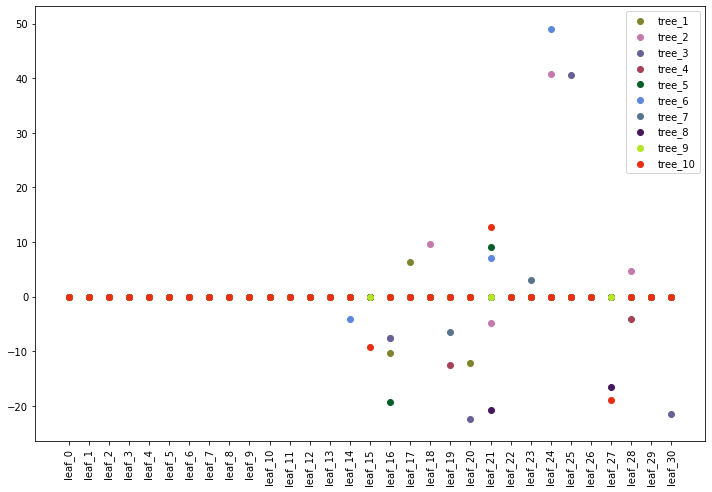

In [85]:
plt.figure(figsize = (12, 8))
legend = []

for offset in np.arange(0, 10):
    
    color = np.random.rand(3)
    plt.scatter(chart_columns, lasso.coef_[(offset * 31):((offset + 1) * 31)], color=color);
    legend.append('tree_' + str(offset + 1))
    
plt.xticks(rotation = 90);
plt.legend(legend);

**Визуализация реального таргета и его прогноза (последние 100 точек, сортировка по дате):**

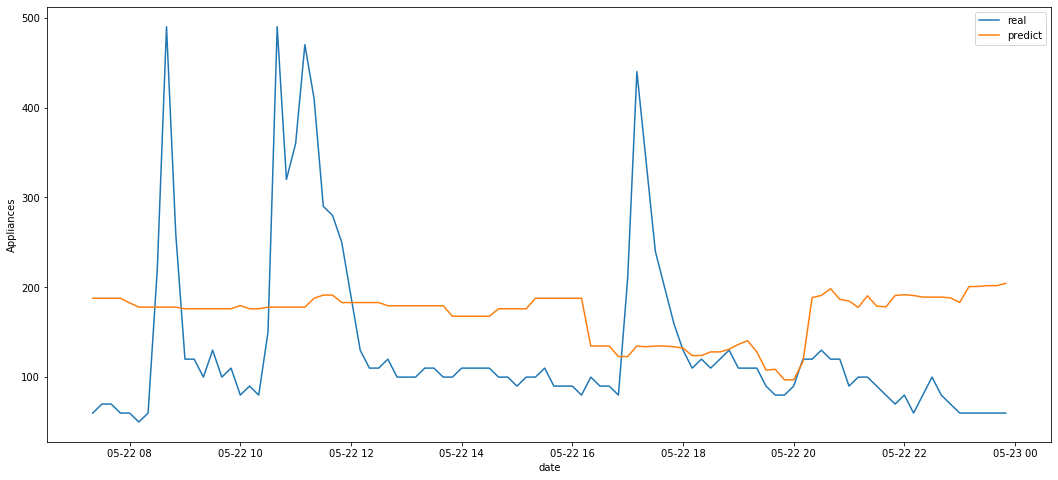

In [86]:
plt.figure(figsize = (18, 8))
plt.plot(y_test[-100:].index, y_test[-100:]);
plt.plot(y_test[-100:].index, lasso.predict(test_set)[-100:]);
plt.xlabel('date');
plt.ylabel('Appliances');
plt.legend(['real', 'predict']);

**На веса модели накинем случайный шум 20 раз и с помощью каждого инстанса зашумлённой модели получаем прогноз**

Например, $w' = w \tau,\ \tau \sim \mathcal{N}(1,\ 0.2)$

In [87]:
%%time

lasso_noise = Lasso(alpha=0.666)

lasso_noise.fit(train_set, y_train)

Wall time: 2.6 s


Lasso(alpha=0.666)

In [92]:
%%time

# параметры нормального распределения:
mu, sigma = 1, 0.2

lasso_noise_coef = lasso_noise.coef_
df_predict_test = pd.DataFrame()

for i in np.arange(0, 20):
    
    lasso_noise.coef_ = lasso_noise_coef * np.random.normal(mu, sigma, len(lasso.coef_))
    
    column = 'predict_' + str(i)
    
    df_predict_test[column] = list(lasso_noise.predict(test_set))

Wall time: 2.58 s


In [103]:
df_predict_test['quantile_l'] = df_predict_test.quantile(0.05, axis=1)
df_predict_test['quantile_u'] = df_predict_test.quantile(0.95, axis=1)
df_predict_test['mean'] = df_predict_test.mean(axis=1)
df_predict_test['real'] = list(y_test['Appliances']) # добавляем столбец с реальными значениями

In [107]:
df_predict_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,...,predict_14,predict_15,predict_16,predict_17,predict_18,predict_19,quantile_l,quantile_u,mean,real
0,108.195629,98.482669,114.538318,102.572000,89.631695,101.328019,101.509063,97.406276,91.496781,87.373809,...,87.877986,109.813252,109.122648,83.256829,113.011486,94.301809,83.344829,114.538318,98.610762,60.0
1,108.195629,98.482669,114.538318,102.572000,89.631695,101.328019,101.509063,97.406276,91.496781,87.373809,...,87.877986,109.813252,109.122648,83.256829,113.011486,94.301809,83.344829,114.538318,98.176735,50.0
2,89.053399,82.421599,95.579107,86.027665,73.879452,82.237197,83.717137,78.974174,73.043494,72.580959,...,73.705795,96.242265,89.130043,64.306600,91.883711,74.922724,64.483465,96.242265,81.565007,50.0
3,89.053399,82.421599,95.579107,86.027665,73.879452,82.237197,83.717137,78.974174,73.043494,72.580959,...,73.705795,96.242265,89.130043,64.306600,91.883711,74.922724,64.483465,96.242265,81.565007,50.0
4,89.053399,82.421599,95.579107,86.027665,73.879452,82.237197,83.717137,78.974174,73.043494,72.580959,...,73.705795,96.242265,89.130043,64.306600,91.883711,74.922724,64.483465,96.242265,81.999035,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,212.081217,230.884644,220.851594,233.957005,215.729228,216.477998,210.212875,246.852764,158.408173,250.243561,...,246.516806,239.566681,229.826753,215.233414,209.342615,190.959343,159.043552,246.852764,213.116803,60.0
2012,212.916915,231.547113,221.041471,234.590998,216.487914,216.923195,210.220385,247.450747,158.922285,250.508308,...,246.896544,239.700356,230.481482,215.514884,209.988055,190.971565,159.548899,247.450747,213.545362,60.0
2013,213.876308,232.271119,221.990876,235.108832,217.303120,217.741031,211.046659,248.484955,160.011337,251.410802,...,247.918118,240.411088,231.066571,216.150083,210.912976,191.988419,160.634067,248.484955,214.376052,60.0
2014,213.876308,232.271119,221.990876,235.108832,217.303120,217.741031,211.046659,248.484955,160.011337,251.410802,...,247.918118,240.411088,231.066571,216.150083,210.912976,191.988419,160.634067,248.484955,214.376052,60.0


**Визуализируем последние 500 объектов из train set (таргет + прогноз + прозрачным цветом область доверительного интервала):**

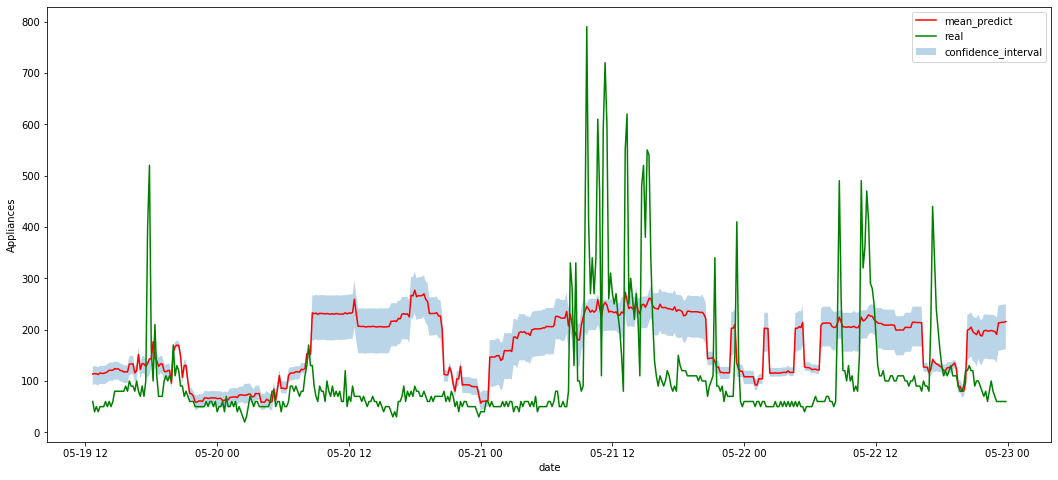

In [112]:
plt.figure(figsize = (18, 8));
plt.fill_between(X_test.index[-500:], df_predict_test['quantile_l'][-500:], df_predict_test['quantile_u'][-500:], alpha=0.3);
plt.plot(X_test.index[-500:], df_predict_test['mean'][-500:], c='red');
plt.plot(X_test[-500:].index, y_test[-500:], c='green');
plt.xlabel('date');
plt.ylabel('Appliances');
plt.legend(['mean_predict', 'real', 'сonfidence_interval']);